# Spin simulator tutorial

This tutorial will teach you how to simulate spin dynamics of the system of QDs with __spin_simulator__ module. You will learn how to compute the dynamics of internal system parameters and track additional parameters such as fidelity, purity, evolution of subsystems etc. 

The tutorial is regularly updated with various examples such as Rabi oscillations, individual electron manipulation with *g*-factor variation, exchange-driven effects, quantum gates and algorithms.

The theoretical foundations of the simulator could be found in the write-up file: https://www.overleaf.com/3252553442tbqcmxntqvtk. 

## 1. Add the current location to path


In order for this tutorial to work, you will need to run this from the "tutorials" folder.

In [3]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))

# This is included so that the Operator Library object file can be loaded into 
# the spin simulator module for this Jupyter Noteboonk tutorial.
os.chdir(os.path.dirname(os.getcwd()))

## 2. Import the relevant modules

In [4]:
#Spin simulator module
import qudipy.spinsimulator.spin_simulator as sps

#Pulse generating module
import qudipy.spinsimulator.pulse_generators as pulsegens

#Circuit module containing control pulses and ideal circuits
import qudipy.circuit as circ

#Constants class
from qudipy.utils.constants import Constants

#For data manipulation
import numpy as np
import qudipy.qutils.matrices as matr
import qudipy.qutils.math as qmath
import math

#For plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick



SPIN: /home/zach/Documents/github/QuDiPy/nn_conversion


## 3. Define the system and pulse parameters

### System: SpinSys object

The system of the electrons in the quantum dots is described by the complex density matrix $\rho$ whose evolution is of interest.
There are several ways to provide information about the initial state:
- the density matrix of the whole system: square 2D array;
- the wavefunction (**ket**-vector) of a pure state: row or column vector as 1D/2D array;
- a list/tuple of density matrices, wavefunctions, or both, that describe subsystems constituting the whole system.

The density matrix of the whole system is generated and stored automatically irrespective of the type of input. 

The current number of electrons in the system $N$ is inferred from the size of $\rho$; if it changes over time (e.g. due to measurements), the parameter $N_0$ should be specified to indicate the maximal possible electron number. Otherwise, the equality $N=N_0$ is assumed.

We create several states relevant for the examples given in the main part of the tutorial. 


In [5]:
#creating an instance of Constants class, assuming that the material is air
consts = Constants("air")

psi_down = np.array([0,1])
psi_up = np.array([1,0])  
    # one electron in pure spin-up/down state
    
rho_up_down = np.kron(np.array([[1,0],[0,0]]) , np.array([[0,0],[0,1]]))    
    # two-electron pure |↑↓> state


You could provide additional constant system parameters such as temperature $T$, Zeeman field $\vec{B_0}= B_0 \hat{z}$, electron spin resonance (ESR) frequency $f_{\scriptsize\text{RF}} = \frac{\omega_{\scriptsize\text{RF}}}{2\pi}$, spin relaxation time $T_1$ and dephasing time $T_2$ to define the system. 

$\color{brown}{\textbf{Note: all units are SI hereinafter, unless otherwise specified}}$

In [6]:
#system parameters needed for a resonant Rabi pulse;
#see the next section for the physical explanation

B0 = 1    
g = 2 
larmor_freq = g *consts.muB *B0 / consts.h

params_rabi = {"B_0":B0, "T_1":2e-4, "T_2":5e-7, "T":4, "f_rf":larmor_freq}    

The central object of the spin simulator is `SpinSys` class. Its instance is used to define the current state of the investigated spin system. It also contains methods responsible for evolving the system spin state and tracking system parameters during the evolution (this will be discussed in the next section). Using the system density matrix and constant parameters, we need to create a SpinSys object to move forward:



In [7]:
rabi_system = sps.SpinSys(psi_up, time=0, **params_rabi)

The default values for the optional keyword arguments are as follows: $T_1=T_2 =\infty\ \mathrm{s}$  (no decoherence), $T = 0\ \mathrm{K}$, $B_0 = 0\ \mathrm{T}$. If unspecified, the ESR frequency is equated to Larmor frequency: $f_{\scriptsize\text{RF}}= \dfrac{g \mu B_0}{h}.$ The `time` parameter incorporates the point in time at which the system is defined; it is optional, too (default value $0\ \mathrm{s}$).


### Control pulses with ControlPulse objects

The control pulse should be defined as an instance of `ControlPulse` class from `qudipy.circuit` module.

In [8]:
rabi_test_pulse = circ.ControlPulse("Rabi test pulse", "effective", pulse_length=1e-6) 
    #pulse for constant Rabi oscillations

The physical quantities that could change during the pulse iclude:  
- RF magnetic field magnitude `"B_rf"` and phase `"phi"` (**in degrees**) in rotation frame
- Deviation g-factor of the $i^{th}$ electron `"delta_g_{i}"`
- Exchange couplings between the $i^{th}$ and $(j)^{th}$ electrons `"J_{ij}"`

They are to be specified as attributes of the `ControlPulse` object by means of its `add_control_variable` method (the unspecified parameters are automaticaclly assigned zero values during the simulation). The sequences of the parameter values should be passed as 1D arrays of equal size; time step is assumed to be constant and is inferred automatically based on the pulse length. 

In [9]:
arrbrf = np.full(3000, 1e-3) #  array of B_rf values
arrphi = np.full(3000, 60) #  array of phi values

# constant Rabi pulse
rabi_test_pulse.add_control_variable(var_name="B_rf", var_pulse=arrbrf) 
rabi_test_pulse.add_control_variable(var_name="phi", var_pulse=arrphi) 

## 3. System evolution 

The method `evolve` of a `SpinSys` object simulates the system evolution under a given pulse or iterable (tuple or list) of pulses. The iterable could be irregular, like, for example, `[pulse1, pulse2, [pulse3, (pulse4, pulse5)], pulse6]`. It returns a dictionary of 1D arrays of the user-specified parameters that are monitored throughout the simulation:
- Purity of the density matrix 
    - Evaluated when `eval_purity=True` is specified
    - `"purity"` entry in the resultant dictionary  
- Fidelity of the density matrix with respect to the theoretical (initial,expected final, etc.) matrix
    - Evaluated when `eval_fidelity=True` and the reference matrix `rho_reference` are specified
    - `"fidelity"` entry in the resultant dictionary  
- 1-electron density submatrices 
    - Evaluated when a qubit / iterable of qubits to track `track_qubits` is specified
    - `"submatrix_{i}"` entry in the resultant dictionary  
-  Bloch vector components $\langle \sigma_{x} \rangle, \langle \sigma_{y} \rangle, \langle \sigma_{z} \rangle$
    - Evaluated when `eval_Bloch_vectors=True` and an iterable of qubits to track `track_qubits` are specified
    - `"sigma_x_{i}"`,`"sigma_y_{i}"`, `"sigma_z_{i}"` entries in the resultant dictionary  
    
The other entry in the final dictionary, `"time"`, incorporates all points in time during the simulation.

An optional parameter `track_points_per_pulse` could be used to record only a part of the parameter values during the pulse to save memory (default is 100). In particular, it could be equated to 2 if one wants to record only the parameters before and after each pulse.

You can monitor the system evolution with the progress bars. If the system evolves under a sequence of pulses, the bars appear for each of them individually.


## 4. Basic examples

### Rabi oscillations

As a simplest example, we consider constant Rabi oscillations with $\phi = 60^\circ$, and assume Lande factor to be $g=2$. 

The Hamiltonian reads as follows: $H = \frac{\hbar(\omega - \omega_{RF})}{2} \sigma_z + \frac{\hbar\Omega}{2} \left( \cos{60^\circ}\ \sigma_x + \sin{60^\circ}\ \sigma_y \right)$, where $\omega = \frac{2\mu_B B_0}{\hbar}$ is Larmor frequency, $ \Omega = \frac{2\mu_B B_{rf}}{\hbar}$ is Rabi frequency _(see the explanation of this and other Hamiltonians in the [write-up](https://www.overleaf.com/project/5f4fcbdd5566fb0001f3b6aa) if needed)_.

At resonance ($\omega = \omega_{RF}$), the electron spin state oscillates between $\left|\uparrow\right>$ and $\left|\downarrow\right>$ with the frequency $\Omega$ by revolving around the axis $ \vec{n}=\left(\frac{1}{2},\ \frac{\sqrt{3}}{2},\ 0\right)^\mathrm{T}$ on the Bloch sphere. Let us simulate it. 

_Note: since this example contains objects defined earlier, re-evaluate all the notebook to run it correctly._

Rabi test pulse, step 3000: 100%|██████████| 3000/3000 [00:01<00:00, 1515.50it/s]


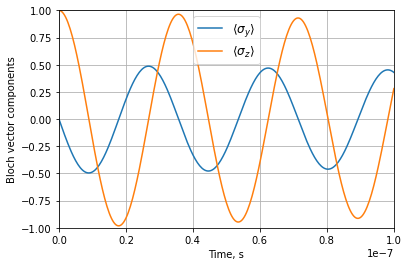

In [10]:
rabi_oscillations = rabi_system.evolve(rabi_test_pulse, 
                               eval_purity=True, 
                               eval_fidelity=True,
                               rho_reference=rabi_system.rho,   
                                       #initial matrix used as a reference
                               track_qubits=1, 
                               eval_Bloch_vectors=True,
                                track_points_per_pulse=2500
)

#showing the oscillating Bloch vector components

plt.plot(rabi_oscillations["time"], 
         np.real(rabi_oscillations["sigma_y_1"]), label="⟨$\sigma_y$⟩") 
plt.plot(rabi_oscillations["time"], 
         np.real(rabi_oscillations["sigma_z_1"]), label="⟨$\sigma_z$⟩")

plt.grid()
plt.rc('grid', linestyle="dashed", color='gray') #adding grid

plt.xlabel("Time, s")
plt.ylabel("Bloch vector components")

plt.legend(loc="upper center", fontsize="large")
plt.axis([0,1e-7,-1,1])
plt.show()


Clearly, the sine waves are shifted by $\frac{\pi}{2}$ in phase, as expected. 
Also, the $y-$component of the Bloch vector $\langle\sigma_y\rangle$ oscillates between the values $\pm \sin\left(90^\circ - 60^\circ\right) =\pm \frac{1}{2}$ because of the way we chose the rotation axis. 
The theoretical oscillation period $T_{\text{theor}}=\pi\hbar/\mu_B B_{\scriptsize\text{RF}} = 35.7\ \mathrm{ns}$  is in good agreement with the simulated result. 

The plots of purity and fidelity with respect to the initial state reveal the dephasing process with time constant $T_2$: 

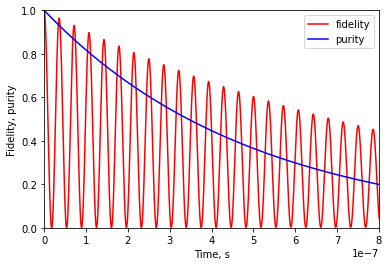

In [11]:
#showing dephasing

plt.plot(rabi_oscillations["time"], 
         np.real(rabi_oscillations["fidelity"]),'r', label="fidelity") 
plt.plot(rabi_oscillations["time"], 
         np.real(rabi_oscillations["purity"]), 'b', label="purity" )

plt.xlabel("Time, s")
plt.ylabel("Fidelity, purity")
plt.legend(loc="upper right")
plt.axis([0,8e-7,0,1])

plt.show()


Since the fidelity of $|\uparrow\rangle$ and $|\uparrow\rangle$ is 1, and the fidelity of $|\uparrow\rangle$ and $|\downarrow\rangle$ is 0, we see the oscillations of this quantity that decay due to decoherence. 
The system purity hits the value $1/e$ at around 500 ns, which is consistent with the definition of $T_2=5\cdot10^{-7} \mathrm{s}$. 
As an exercise, you could check if this equality holds for different system parameters.

### Addressing individual qubits with the deviation $g-$factors

If we could address electron g-factors individually, we could tune them on and off resonance. Indeed, the Hamiltonian in this case is as follows (phase is still zero):

$$H = \sum_i \frac{\hbar}{2}\left(\omega\left(1+\frac{\delta g_i}{2}\right) - \omega_{\scriptsize\text{RF}} \right) \sigma_{z,i} + \frac{\hbar\Omega}{2} \sigma_{x,i}$$

Consider a two-electron system in the $\left|\uparrow\downarrow\right>$ configuration. In this case, we need to specify `delta_g_{i}` control variables. We specify meander-like sequences for them:

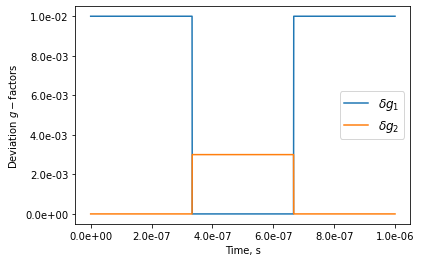

In [12]:
#creating spin system, starting with the same parameters as before
g_manip_system = sps.SpinSys(rho_up_down, **params_rabi) 
#reducing dissipation
g_manip_system.T_2 = 1e-5

lisdg1 = [1e-2] * 1000 + [0] * 1000 + [1e-2] * 1000   #delta_g_1 pulse
lisdg2 = [0] * 1000 + [3e-3] * 1000 + [0] * 1000      #delta_g_2 pulse

#plotting pulses 
listime = np.linspace(0, 1e-6, num=3000)

fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
     # for scientific  number format

ax.plot(listime, lisdg1, label = '$\delta g_1$')
ax.plot(listime, lisdg2, label = '$\delta g_2$')

ax.set_xlabel("Time, s")
ax.set_ylabel("Deviation $g-$factors")
ax.legend(loc='center right', fontsize='large')


The other variables are chosen so that no deviation in $g-$factor corresponds to the resonance

In [13]:
#starting with the same pulse as before
g_manip_pulse = rabi_test_pulse
g_manip_pulse.name = "g-factor manipulation pulse"

# adding g factor control variables 
g_manip_pulse.add_control_variable("delta_g_1", np.array(lisdg1))
g_manip_pulse.add_control_variable("delta_g_2", np.array(lisdg2))

# performing the system evolution
g_manip = g_manip_system.evolve(g_manip_pulse, track_qubits={1,2}, 
                                eval_Bloch_vectors=True,track_points_per_pulse=1000)    


g-factor manipulation pulse, step 3000: 100%|██████████| 3000/3000 [00:02<00:00, 1455.55it/s]


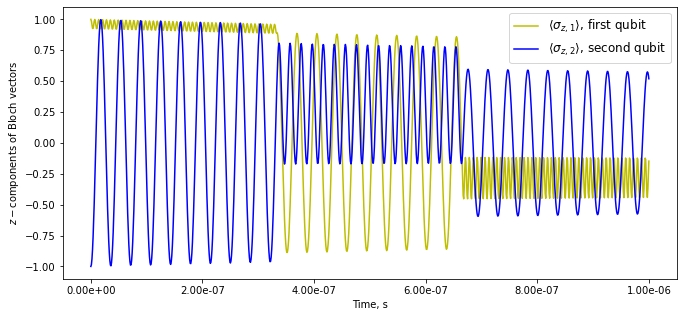

In [14]:
#plotting the results
fig, ax = plt.subplots(figsize=(11,5))    #making the figure wider

ax.plot(g_manip["time"], np.real(g_manip["sigma_z_1"]) ,"y", label = "⟨$\sigma_{z,1}$⟩, first qubit") 
ax.plot(g_manip["time"], np.real(g_manip["sigma_z_2"]) ,"b", label = "⟨$\sigma_{z,2}$⟩, second qubit") 
ax.legend(loc='upper right', fontsize='large')

ax.set_xlabel("Time, s")
ax.set_ylabel("$z-$components of Bloch vectors")
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
     # for scientific  number format


We clearly observe residual oscillations even at large deviation $g$-factor. This happens because the detuned qubit does not return to its initial state after the resonance. The optimal way to choose $\delta g$ is implemented in `pulsegens` module for control pulse generation (see the [write-up](https://www.overleaf.com/3252553442tbqcmxntqvtk) for the derivation and next section for the examples).

### Exchange interaction; scaling up to larger qubit ensembles
The exchange interaction in a chain of qubits is described by the Heisenberg Hamiltonian: $H_{ex} = \sum_i \frac{J_i}{4} \vec{\sigma}_i \cdot \vec{\sigma} _{i+1}$, where $J_i$ are exchange parameters. Knowing that a $ \mathrm{SWAP}$ operator is given by $$ \mathrm{SWAP} = \frac{1}{2}\left(\mathbb{1}_1\mathbb{1}_2 + X_1 X_2 + Y_1 Y_2 +Z_1 Z_2  \right)$$ and that $ \mathrm{SWAP}^2 = \mathbb{1}_1\mathbb{1}_2$, we could write the time evolution operator for a 2-qubit system:

$$U_J = \exp \left( -\frac{iHt}{\hbar}\right) = \exp \left(\frac{iJt}{2\hbar} \right)\exp \left(-\frac{iJt}{2\hbar} \mathrm{SWAP} \right)
= \exp \left(\frac{iJt}{2\hbar} \right) \left( \cos \frac{Jt}{2\hbar} \mathbb{1}_1\mathbb{1}_2 - i \sin\frac{Jt}{2\hbar} \mathrm{SWAP}\right)
$$ 

Neglecting the global phase factor, we conclude that the $\mathrm{SWAP}$ gate is realized when $\frac{Jt}{2\hbar}= \frac{\pi}{2}$, so we obtain $t(\mathrm{SWAP})= \frac{\pi \hbar}{J} = \frac{h}{2J} $. Consequently,  $t(\mathrm{\sqrt{SWAP}}) = \frac{h}{4J}.$

#### Two qubit exchange pulse

To start with, let us test pure exchange oscillations in the isolated 2-qubit system in the $\left|\downarrow\uparrow\right>$ configuration.

2_qubit_exchange_pulse, step 500: 100%|██████████| 500/500 [00:00<00:00, 1675.62it/s]


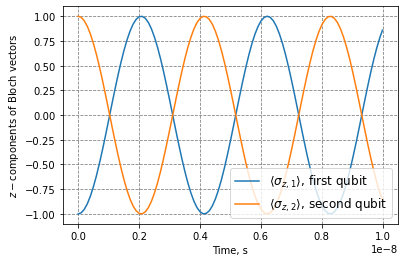

Theoretical value of SWAP time: 2.0706e-09 s


In [15]:
exch_system = sps.SpinSys([psi_down, psi_up])
#default system parameters, specifyning a list of two wavefunctions

exch_pulse = circ.ControlPulse("2_qubit_exchange_pulse", "effective", pulse_length=1e-8)
J_0 = 1.6e-25

arrj= np.full(500, J_0)
exch_pulse.add_control_variable("J_1", arrj)
exch = exch_system.evolve(exch_pulse, track_qubits={1,2}, eval_Bloch_vectors=True)


plt.plot(exch["time"],  np.real(exch["sigma_z_1"]), label = "⟨$\sigma_{z,1}$⟩, first qubit") 
plt.plot(exch["time"],  np.real(exch["sigma_z_2"]), label = "⟨$\sigma_{z,2}$⟩, second qubit")

plt.grid()
plt.rc('grid', linestyle="dotted", color='gray') #adding grid

plt.xlabel("Time, s")
plt.ylabel("$z-$components of Bloch vectors")
plt.legend(loc="lower right", fontsize='large')

plt.show()
print("Theoretical value of SWAP time: {:.5} s".format(consts.h/(2*J_0)))

Estimate the simulated value of SWAP time from the plot you have obtained and check if it is consistent with the theoretical one.

#### Spin wave in a ferromagnet

Let us consider a 6-qubit system in the $\left|\downarrow \uparrow \uparrow \uparrow \uparrow \uparrow\right>$ configuration. Let us also assume that the chain is ferromagnetic, i.e. all $J_i<0$. The ground state of such a system is achieved when all the spins are parallel. Since there is a flipped spin on the left side, we expect that it will travel to the right, i.e. induce a spin wave.

$\color{red}{\textbf{Caution:}\text{ this simulation may take a long time to complete.}}$

spin_wave_pulse, step 500: 100%|██████████| 500/500 [00:18<00:00, 26.56it/s]


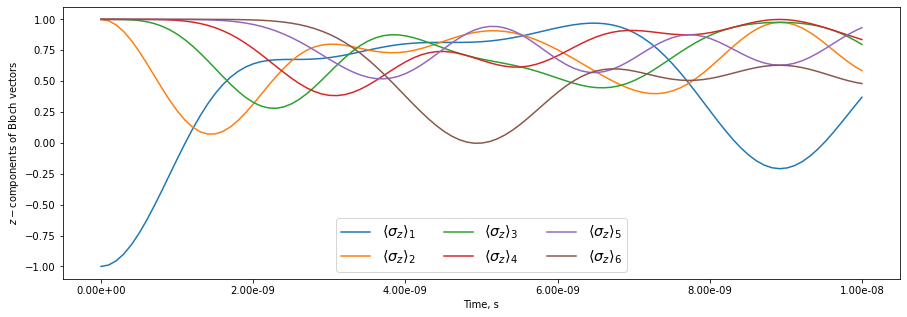

In [16]:
#defining the system
psi_six = [psi_down] + [psi_up] * 5

six_el_system = sps.SpinSys(psi_six, B_0=B0 )  
sw_pulse =  circ.ControlPulse("spin_wave_pulse", "effective", pulse_length=1e-8) #picoseconds

# defining exchange between all the electrons in the chain 
for i in range(1,7):
    sw_pulse.add_control_variable("J_{}".format(i), -1 * arrj)
sw = six_el_system.evolve(sw_pulse, track_qubits={1,2,3,4,5,6}, eval_Bloch_vectors=True)

fig, ax = plt.subplots(figsize=(15,5))
#fig = plt.figure(figsize=(11,4))
for i in range(1,7):
    ax.plot(sw["time"], np.real(sw["sigma_z_{}".format(i)]) , label=('⟨$\sigma_{z}$⟩'+'$_{}$'.format(i)))

ax.legend(loc='lower center', fontsize='x-large',ncol=3)
plt.xlabel("Time, s")
plt.ylabel("$z-$components of Bloch vectors")

ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
     # for scientific  number format
    

As expected, the spins are disturbed consecutively from left to right.

## 5. Simulating quantum gates

### Basic pulse generators
The `pulsegens` module contains the simple constant pulse generators for the most basic single- and two-qubit operations like single-qubit rotations, $\mathrm{SWAP}$,  $\mathrm{\sqrt{SWAP}}$. See the [write-up](https://www.overleaf.com/3252553442tbqcmxntqvtk) for the background theory of how the pulses are synthesized.

Keep in mind that the generation of the "realistic" pulses requires much more complicated optimal control methods. The only purpose of the `pulsegens` module is to show the simulation of spin dynamics in action.

### Single qubit rotations

The function `rot_square` from `pulsegens` module that produces single-qubit square ESR pulses requires the following parameters:
- `qubits`: the qubit(s) to evolve under the pulse
- `axis`: "X", "Y" or "Z"
- `theta`: value in **degrees**
- `B_rf`: magnitude of the ESR field

The optional keyword arguments are as follows:
- `num_val`: number of data points in the obtained pulse (default is 300),
- `B_0` and `f_rf`. The default values for them are, just as before, $0\ \mathrm{T}$ and Larmor frequency, respectively.
- `delta_g`: the *approximate* value of deviation $g-$factor used for detuning qubits from resonance when needed (zero by default). The *exact* value is calculated under the hood, since there exists a discrete set of exact $\delta g$ values that are optimal for ESR rotation, see the [write-up](https://www.overleaf.com/3252553442tbqcmxntqvtk) for the derivation.

As an example, we will evolve the $\left|+\right> = \frac{1}{\sqrt{2}} \left(\left|\uparrow\right> + \left| \downarrow \right> \right)$  state with the $\mathrm{ROTZ}(\theta)$ gate at $\theta = 45^\circ$. Such a gate is constructed in `pulsegens` as follows: 
$$\mathrm{ROTZ}(\theta) = \mathrm{ROTX}(-90^\circ) \ \mathrm{ROTY}(\theta) \ \mathrm{ROTX}(90^\circ).$$

As a side note, the other way to build it is by properly detuning the system from resonance with the deviation $g-$factor; this method is left as an exercise for the reader.


ROTX_90, step 100: 100%|██████████| 100/100 [00:00<00:00, 1873.75it/s]


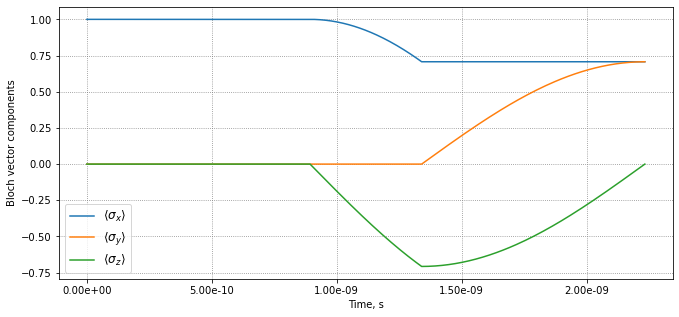

In [17]:
# Implementing ROTZ(45) gate

rho_plus = np.array([[0.5,0.5],[0.5,0.5]])
rotz_system = sps.SpinSys(rho_plus, B_0=1, T_2=1e-4, T=4, 
                                                   f_rf=larmor_freq*0.7, time=0)

# ROTZ gate; mind that the angle is given in degrees
rotz_pi_4_pulse = pulsegens.rot_square(qubits=1, N=1, axis="Z", theta=45, B_0=rotz_system.B_0,
                                       B_rf=1e-2, f_rf=rotz_system.f_rf, num_val=100)

rotz_pi_4 = rotz_system.evolve((rotz_pi_4_pulse,),
                               track_qubits=1, eval_Bloch_vectors=True)
#plotting the results
fig, ax = plt.subplots(figsize=(11,5))

ax.plot(rotz_pi_4["time"], np.real(rotz_pi_4["sigma_x_1"]) , label='⟨$\sigma_x$⟩')
ax.plot(rotz_pi_4["time"], np.real(rotz_pi_4["sigma_y_1"]) , label='⟨$\sigma_y$⟩')
ax.plot(rotz_pi_4["time"], np.real(rotz_pi_4["sigma_z_1"]) , label='⟨$\sigma_z$⟩')

ax.legend(loc='lower left', fontsize='large')
plt.xlabel("Time, s")
plt.ylabel("Bloch vector components")

ax.grid()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
     # for scientific  number format


Check that the order of simulated Bloch vector rotations is consistent with the theoretical predictions: 
1. No turn, since the initial state is an eigenstate of $\sigma_x$.
2. Turn by $45^\circ$ in $x-z$ plane (around $\hat{y}$ axis).
3. Move towards the position between $\hat{x}$ and $\hat{y}$ axes in the $x-y$ plane.

#### $\mathrm{SWAP} $ and $ \mathrm{\sqrt{SWAP}}$ gates

These gates have already been discussed in section 4. The duration of the constant exchange pulse is as follows:

$t(\mathrm{SWAP}) = \frac{h}{2J}; \quad t(\mathrm{\sqrt{SWAP}}) = \frac{h}{4J}.$ 

The generators of these operators require the tuple of the two interacting qubit indices (variable `qubits`), and the magnitude of $J$ as parameters. *Mind that the simulator currently supports only nearest-neighbor exchange, so `qubits` should be of the form $(k, k\pm 1)$, where $k$ is integer.*
The keyword arguments `B_0`, `f_rf` and `num_val` are optional. Their default values are the same as in all other cases discussed previously.

In the example below, we test that the state $\left|\uparrow\downarrow\right>$ is transformed into $\left|\downarrow\uparrow\right>$ upon $\mathrm{SWAP}$ and check the fidelity with the theoretically predicted density matrix.

In [18]:
#final density matrix in the ideal case
rho_down_up = np.kron([[0,0],[0,1]], [[1,0],[0,0]])

swap_system = sps.SpinSys(rho_up_down, T_2=1e-6)
swappulse = pulsegens.swap(N=2, qubits=(1,2), J=1e-25, num_val=500)

swap = swap_system.evolve(swappulse)
print("Fideity with respect to |↓↑⟩ after SWAP: {:.8}".format(
                    qmath.fidelity(swap_system.rho, rho_down_up)))
print("Duration of the SWAP pulse: {:.4} ns".format(swap_system.time * 1e9))

SWAP_1_2, step 500: 100%|██████████| 500/500 [00:00<00:00, 2178.32it/s]

Fideity with respect to |↓↑⟩ after SWAP: 0.99669245
Duration of the SWAP pulse: 3.313 ns


#### CZ and CNOT gates

Now let us test the performance of such two-qubit gates as $\mathrm{CZ}$ and $\mathrm{CNOT}$. As is well known, they are defined by the following matrices:

In [19]:
cz = np.diag([1,1,1,-1])
cnot = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]], dtype=complex)

The network architecture we are aimining at simulating is based on single-qubit rotations and $\mathrm{\sqrt{SWAP}}$ gates. Thus, we express $\mathrm{CZ}$ and  $\mathrm{CNOT}$ in terms of those gates according to [Buonacorsi et al, 2019](https://iopscience.iop.org/article/10.1088/2058-9565/aaf3c4/pdf).

The following notation is the same as .circ files, see the **"Loading control pulse (.ctrlp) and quantum circuit (.qcirc) files"** tutorial for explanation. The raw input will be transformed to .circ files with the drawn diagrams at some point:


These composite $\mathrm{CZ}$ and $\mathrm{CNOT}$ gates will be checked on a randomly defined pure two-qubit system:

In [20]:
temp = np.random.rand(4,1) + np.random.rand(4,1)*1j          # random complex vector 4x1
rand_state = temp / np.linalg.norm(temp)                     # properly defined state vector (random vector normalized by its norm)
rho_rand = np.kron(rand_state, rand_state.T.conj())          # random pure 2-electron density matrix

print("Random 2-qubit pure density matrix:\n {}".format(np.round(rho_rand, 4)))    # np.round is used not to deal with the global precision settings
                                                             # in np.set_printoptions  

Random 2-qubit pure density matrix:
 [[0.4052+0.j     0.2155+0.1974j 0.1595+0.0572j 0.343 -0.0961j]
 [0.2155-0.1974j 0.2108+0.j     0.1127-0.0473j 0.1356-0.2182j]
 [0.1595-0.0572j 0.1127+0.0473j 0.0708+0.j     0.1214-0.0862j]
 [0.343 +0.0961j 0.1356+0.2182j 0.1214+0.0862j 0.3131+0.j    ]]


Now let us simulate $\mathrm{CZ}$ and  $\mathrm{CNOT}$ gates by realizing the sequences of ESR and exchange pulses defined above.
We also create `ideal` matrices corresponding to the initial matrix transformed under the ideal gates (`cz` and `cnot`). They are used to calculate fidelity of the simulated density matrix after the sequence of pulses. Apart from that, we monitor how the purity changes.

__Remark__: if the value of fidelity you obtain (e.g for different parameters) is too small, it could be due to the lack of precision in the simulation. Try increasing the values of `num_val` for the pulses.  

Let us start with the $\mathrm{CZ}$ gate applied on the system with the density matrix `rho_rand`.

In [21]:
#defining random system  with a small off-resonance frequency shift
params = {"B_0" : B0, "f_rf"  : larmor_freq*0.995}
rand_sys = sps.SpinSys(rho_rand, **params)

#defining CZ sequence
B_rf=1e-4
J=1e-24
delta_g = 1e-4

rz90_1 = pulsegens.rot_square(qubits=1, N=rand_sys.N_0, axis="Z", theta=90, 
                              **params, B_rf=B_rf, num_val=1300, delta_g=delta_g)
rzmin90_2 = pulsegens.rot_square(2, rand_sys.N_0, "Z", -90,  B_rf=B_rf, delta_g=delta_g, 
                                 **params, num_val=500)
rswap = pulsegens.rswap([1,2], rand_sys.N_0, J, **params, num_val=1000)
rz180_1 = pulsegens.rot_square(1, rand_sys.N_0, "Z", 180, B_rf=B_rf, **params, num_val=700)

cz_seq = [rz90_1, rzmin90_2, rswap, rz180_1 , rswap]

rand_sys.evolve(cz_seq)
ideal = cz @ rho_rand @ cz.T.conj()

# There is no need to track the fidelity and purity during the pulse
# so we calculate them once, right after the end of the pulse

print("Fideity after CZ: {:.8}".format(qmath.fidelity(rand_sys.rho, ideal)))
print("Purity after CZ: {:.8}".format(qmath.purity(rand_sys.rho)))
print("\nSimulated density matrix:\n", np.round(rand_sys.rho,4), "\n\nAfter the evolution under ideal gate" , '\n',np.round(ideal, 4))


RSWAP_1_2, step 1000: 100%|██████████| 1000/1000 [00:00<00:00, 2083.66it/s]


Fideity after CZ: 0.99948649
Purity after CZ: 0.99898827

Simulated density matrix:
 [[ 0.4052+0.j      0.2153+0.198j   0.1588+0.0572j -0.3432+0.0939j]
 [ 0.2153-0.198j   0.2112+0.j      0.1124-0.0471j -0.1366+0.2178j]
 [ 0.1588-0.0572j  0.1124+0.0471j  0.0704+0.j     -0.1212+0.0855j]
 [-0.3432-0.0939j -0.1366-0.2178j -0.1212-0.0855j  0.3131+0.j    ]] 

After the evolution under ideal gate 
 [[ 0.4052+0.j      0.2155+0.1974j  0.1595+0.0572j -0.343 +0.0961j]
 [ 0.2155-0.1974j  0.2108+0.j      0.1127-0.0473j -0.1356+0.2182j]
 [ 0.1595-0.0572j  0.1127+0.0473j  0.0708+0.j     -0.1214+0.0862j]
 [-0.343 -0.0961j -0.1356-0.2182j -0.1214-0.0862j  0.3131+0.j    ]]


As an exercise, compare the two matrices shown above and estimate the error of the numerical simulation depending on the values of `num_val` parameters.

Now let us apply $\mathrm{CNOT}$ gate on the same system (that has just evolved under $\mathrm{CZ}$). As an exercise, you could run the cell several times in a row: each run will correspond to a new $\mathrm{CNOT}$ applied. You will notice that the values of fidelity and purity will decrease over time. 

In [22]:
#saving the value of density matrix before the pulse to track the ideal evolution
new_rho_rand = rand_sys.rho 

rymin90_2 =  pulsegens.rot_square(2, rand_sys.N_0, "Y", -90,  B_rf=B_rf, delta_g=delta_g, 
                                 **params, num_val=1400)
ry90_2 =  pulsegens.rot_square(2, rand_sys.N_0, "Y", 90, B_rf=B_rf, delta_g=delta_g, **params)

cnot_seq = [rymin90_2, cz_seq, ry90_2]

rand_sys.evolve(cnot_seq)
ideal = cnot @ new_rho_rand @ cnot.T.conj()

print("\nFideity after CNOT: {:.8}".format(qmath.fidelity(rand_sys.rho, ideal)))
print("Purity after CNOT: {:.8}".format(qmath.purity(rand_sys.rho)))
print("\nSimulated density matrix:\n", np.round(rand_sys.rho,4), 
          "\n\nAfter the evolution under ideal gate:" , '\n',np.round(ideal, 4))


ROTY_90, step 300: 100%|██████████| 300/300 [00:00<00:00, 1916.92it/s]



Fideity after CNOT: 0.99969283
Purity after CNOT: 0.99720413

Simulated density matrix:
 [[ 0.406 +0.j      0.2152+0.198j  -0.3434+0.0906j  0.1586+0.0588j]
 [ 0.2152-0.198j   0.2107+0.j     -0.1377+0.2158j  0.1127-0.0462j]
 [-0.3434-0.0906j -0.1377-0.2158j  0.3125+0.j     -0.1213-0.0854j]
 [ 0.1586-0.0588j  0.1127+0.0462j -0.1213+0.0854j  0.0707+0.j    ]] 

After the evolution under ideal gate: 
 [[ 0.4052+0.j      0.2153+0.198j  -0.3432+0.0939j  0.1588+0.0572j]
 [ 0.2153-0.198j   0.2112+0.j     -0.1366+0.2178j  0.1124-0.0471j]
 [-0.3432-0.0939j -0.1366-0.2178j  0.3131+0.j     -0.1212-0.0855j]
 [ 0.1588-0.0572j  0.1124+0.0471j -0.1212+0.0855j  0.0704+0.j    ]]
